In [ ]:
from pathlib import Path
from asim.dataset.scene.arrow_scene import ArrowScene

In [ ]:
)

<Axes: title={'center': 'Map: nuplan_us-nv-las-vegas-strip'}>

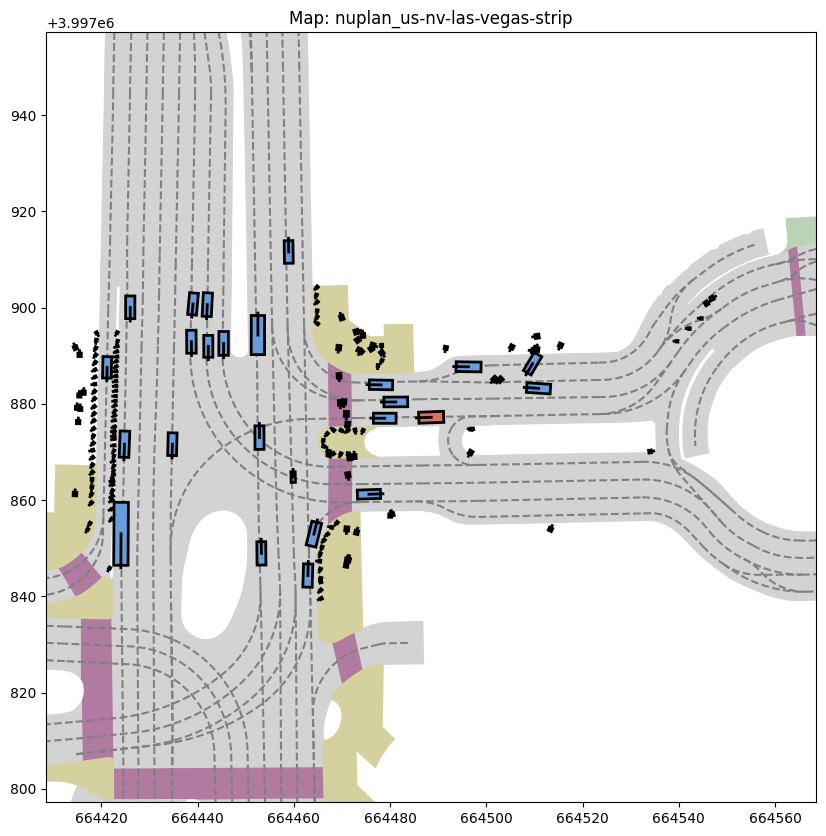

In [ ]:
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt

import numpy as np

from asim.common.geometry.base import Point2D
from asim.common.geometry.bounding_box.bounding_box import BoundingBoxSE2, BoundingBoxSE3
from asim.common.geometry.tranform_2d import translate_along_yaw
from asim.common.visualization.maps.plot_maps import _plot_map_on_ax_v2
from asim.common.visualization.color.lib.ellis import ELLIS_5
from asim.dataset.scene.abstract_scene import AbstractScene




def plot_bounding_box(ax, box: Union[BoundingBoxSE2, BoundingBoxSE3], color: str = "red", alpha: float = 1.0) -> None:
    box_polygon = box.shapely_polygon
    x, y = box_polygon.exterior.xy
    ax.fill(x, y, color=color, alpha=alpha, edgecolor="black", linewidth=2, zorder=3)
    arrow = np.zeros((2, 2))

    arrow[0] = box.center.state_se2.point_2d.array
    arrow[1] = translate_along_yaw(box.center.state_se2, Point2D(box.length / 2.0 + 0.5, 0.0)).point_2d.array
    ax.plot(arrow[:, 0], arrow[:, 1], color="black", alpha=alpha, linewidth=2, zorder=3)


def plot_scene_at_iteration(scene: AbstractScene, iteration: int = 0, ax: Optional[plt.Axes] = None):

    radius = 100

    ego_vehicle_state = scene.get_ego_vehicle_state_at_iteration(iteration)
    box_detections = scene.get_box_detections_at_iteration(iteration)
    traffic_light_detections = scene.get_traffic_light_detections_at_iteration(iteration)
    map_api = scene.map_api

    point_2d = ego_vehicle_state.bounding_box.center.state_se2.point_2d

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    _plot_map_on_ax_v2(ax, map_api, point_2d, radius=radius)

    for box_idx, box in enumerate(box_detections.box_detections):
        plot_bounding_box(ax, box.bounding_box_se3, color=ELLIS_5[4].hex, alpha=1.0)

    plot_bounding_box(ax, ego_vehicle_state.bounding_box, color=ELLIS_5[0].hex, alpha=1.0)

    buffer_radius = 0.8 * radius
    ax.set_xlim(point_2d.x - buffer_radius, point_2d.x + buffer_radius)
    ax.set_ylim(point_2d.y - buffer_radius, point_2d.y + buffer_radius)

    ax.set_aspect("equal", adjustable="box")

    return ax

log_name = "2021.06.14.17.26.26_veh-38_04544_04920"
log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")
scene = ArrowScene(log_file)

plot_scene_at_iteration(scene, iteration=100)

In [12]:
import io

from PIL import Image
from tqdm import tqdm


def create_animation_gif(start_idx=0, end_idx=None, step=10, fps=20):
    if end_idx is None:
        end_idx = len(scene._recording_table)
    # Calculate duration per frame in milliseconds
    duration = int(1000 / fps)

    # Create frames
    images = []
    for i in tqdm(range(start_idx, end_idx, step)):
        fig, ax = plt.subplots(figsize=(10, 10))
        plot_scene_at_iteration(scene, i, ax)

        # Creating PIL image from fig
        buf = io.BytesIO()
        fig.savefig(buf, format="png")
        buf.seek(0)
        images.append(Image.open(buf).copy())

        # Close buffer and figure
        buf.close()
        plt.close(fig)

    # Save the GIF with the specified FPS
    images[0].save(f"{log_name}.gif", save_all=True, append_images=images[1:], duration=duration, loop=0)

log_name = "2021.06.14.17.26.26_veh-38_04544_04920"
log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")
scene = ArrowScene(log_file)

# Create a gif animation with a specific FPS
create_animation_gif(fps=30, end_idx=None, step=10)

100%|██████████| 752/752 [04:17<00:00,  2.92it/s]
